In [1]:
import os

def toRelPath(origPath):
    """Converts path to path relative to current script

    origPath:	path to convert
    """
    try:
        if not hasattr(toRelPath, "__location__"):
            toRelPath.__location__ = os.path.realpath(os.path.join(os.getcwd(), os.path.dirname(__file__)))
        return os.path.join(toRelPath.__location__, origPath)
    except NameError:
        return origPath

####end of library

In [2]:
import json
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm

PRICE_POINT_EPS = 1e-8
PRICE_MAX = 1000000

In [36]:
events = json.load(open(toRelPath("db.json")))
events.sort(key=lambda x: x[0])
print(events[5000])
print("Events:", len(events))

#stats to watch while walking through time
eventSeries = {
    "time": [],
    "low": [],
    "high": [],
    "last-trade": []
}

[5000, 1531796919659, 0, 6723.71, 0.1, 2]
Events: 10544


In [37]:
for event in events:
    #check for prince point granularity
    maxPrice = max(event[3], maxPrice)
print(maxPrice)

1000000.0


In [38]:
#assume price points are in cent granularity
#bid, ask
curOB = [[0.0] * (100 * PRICE_MAX + 1), [0.0] * (100 * PRICE_MAX + 1)]

maxBid = 0
minAsk = PRICE_MAX * 100
lastTradePrc = 0

for event in events:
    #special events are identified by the reason
    if event[5] == 0 or event[5] == 1:
        continue
    
    #check for prince point granularity
    pp = round(event[3] * 100)
    if event[3] * 100 - pp >= PRICE_POINT_EPS:
        print("Price point diff:", event[3], event[3] * 100 - pp)
        continue

    #update orderbook min/max
    ind = 0
    if event[2] == 1: #ask
        ind = 1
        if event[4] > 0:
            minAsk = min(minAsk, pp)
        else:
            for minAsk in range(minAsk + 1, PRICE_MAX + 1):
                if curOB[1][minAsk] > 0:
                    break
    else: #bid
        if event[4] > 0:
            maxBid = max(maxBid, pp)
        else:
            for maxBid in range(minAsk + 1, -1, -1):
                if curOB[0][maxBid] > 0:
                    break
                    
    #update ob
    curOB[ind][pp] = event[4]
    
    #calculate price of last trade
    if event[5] == 3: #trade event
        lastTradePrc = event[3]
    
    if maxBid == 0 or minAsk == PRICE_MAX * 100 or lastTradePrc == 0:
        continue
        
    #orderbook is ready at this point
    
    #calculate some stats
    eventSeries["time"].append(datetime.datetime.fromtimestamp(event[1]//1000))
    eventSeries["low"].append(maxBid / 100)
    eventSeries["high"].append(minAsk / 100)
    eventSeries["last-trade"].append(lastTradePrc)

In [39]:
#free some memory
del events
del curOB

cEvents = len(eventSeries["time"])

print("Max price:", maxPrice)
print("Events: ", cEvents)
print("Estimated memory for 1 series: ", cEvents * (8) / 1000 / 1000, "MB")

Max price: 1000000.0
Events:  6214
Estimated memory for 1 series:  0.049712000000000006 MB


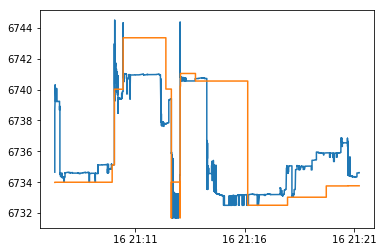

In [40]:
eventSeries["mid"] = []
for a in range(len(eventSeries["time"])):
    eventSeries["mid"].append((eventSeries["low"][a] + eventSeries["high"][a]) / 2)
plt.plot(eventSeries["time"], eventSeries["mid"])
plt.plot(eventSeries["time"], eventSeries["last-trade"])

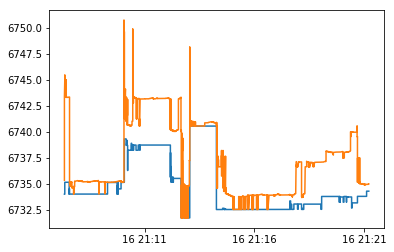

In [41]:
plt.plot(eventSeries["time"], eventSeries["low"])
plt.plot(eventSeries["time"], eventSeries["high"])

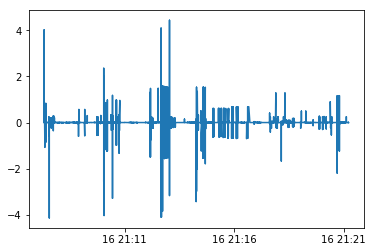

In [42]:
eventSeries["dmid"] = [0]
for a in range(1, len(eventSeries["time"])):
    eventSeries["dmid"].append(eventSeries["mid"][a] - eventSeries["mid"][a - 1])
plt.plot(eventSeries["time"], eventSeries["dmid"])